# Lab 4 - ML Experiments in Python
- **Author:** Qutub Khan Vajihi ([qutubkhan.vajihi@berkeley.edu](mailto:dimitri@berkeley.edu)) (adapted from Dimitris Papadimitriou's Lab)
- **Date:** 17 February 2021
- **Course:** INFO 251: Applied Machine Learning

### Announcements:
1. PS3 due 22nd Feb, 11:59PM. 
2. If your nearest neighbor algorithm takes hours to run, visit us during OH for troubleshooting.
3. If you haven't filled out the quiz preference form yet, please do. 

### Learning Objectives:
By the end of the lab, you will be able to:

* Split a given dataset in random train-test splits using multiple methods.
* Better understand built-in methods for k-fold ross-validation.
* Learn about different measures of performance.

# 1. Random numbers, training and test data

### Why train-test(-validation) splits? 
* Use training set to 'Fit'
* Use test to evaluate performance i.e. see how your model performs on new unseen data. 
* But you cannot keep using the test set again and again, you might end up overfitting to the test set!
* Use a validation or 'development' set for model hyper-parameter tuning.



<img src="train_test_splot.webp" width=800 height=800 />

### Why shuffle/randomize the data?

Randomization is vital in machine learning. Based on the way the dataset has been created, there could be sorting or indexing  or appending that necessitates shuffling of the data before splitting. Say your dataset was sorted on timestamp and you split the data without shuffling - your training contains older datapoints, while your test contains newer ones. This can be problematic! 


By randomizing the order of input data during splitting-  
* We ensure we do not have systematically different training and test sets i.e. they don't have different distributions. 
* The splits are representative of real world data.

### Three ways to split train-test (there could be more!)

In [1]:
import pandas as pd
import numpy as np
import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Let's load some toy data!
auto_df = pd.read_csv('Auto.csv')
auto_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


NameError: name 'hinterland' is not defined

- mpg: Miles per gallon
- cylinders: Number of cylinders between 4 and 8
- displacement: Engine displacement (cu. inches)
- horsepower: Engine horsepower
- weight: Vehicle weight (lbs.)
- acceleration: Time to accelerate from 0 to 60 mph (sec.)
- year: Model year (modulo 100)
- origin: Origin of car (1. American, 2. European, 3. Japanese)
- name: Vehicle name

In [3]:
auto_df.describe()

,mpg,cylinders,displacement,weight,acceleration,year,origin
count,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000
mean,23.515869,5.458438,193.532746,2970.261965,15.555668,75.994962,1.574307
std,7.825804,1.701577,104.379583,847.904119,2.749995,3.690005,0.802549
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.000000,2223.000000,13.800000,73.000000,1.000000
50%,23.000000,4.000000,146.000000,2800.000000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3609.000000,17.100000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


In [4]:
auto_df.horsepower.unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

In [5]:
auto_df = auto_df[auto_df.horsepower != '?']
auto_df['horsepower'] = auto_df['horsepower'].astype('float')

In [6]:
auto_df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [7]:
auto_df.shape

(392, 9)

Let's split this data into training and test sets. Conventionally, 80-20 is a good train-test split, but sometimes 75-25 is also used. 

There are multiple ways to generate random numbers or shuffle data, but we'll look at two ways for now. We'll use `np.random.choce` to generate some random numbers.

`np.random.choce` - 
Generates a random sample from a given 1-D array

- a : Input array
- size : Desired size of output
- replace : Whether the sample is with or without replacement
- p : The probabilities associated with each entry in a. If not given the sample assumes a uniform distribution over all entries in a.

In [8]:
# Let's set a random seed to ensure consistency 
np.random.seed(seed=222)
a = range(len(auto_df))
train_idx = np.random.choice(a, int(len(auto_df) * .8), replace=False) #With replacement will be problematic here!
test_idx = list(set(a) - set(list(train_idx)))

In [9]:
auto_df[train_idx]

KeyError: "None of [Int64Index([163, 374,  16, 259,  19,  98, 204,  85, 265, 230,\n            ...\n            282, 360, 354, 165,  80,  40, 185, 321,  72, 111],\n           dtype='int64', length=313)] are in the [columns]"

Why did that not work? 

In [10]:
auto_df.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            387, 388, 389, 390, 391, 392, 393, 394, 395, 396],
           dtype='int64', length=392)

In [11]:
np.random.seed(seed=222)

a = np.array(auto_df.index)
train_idx = np.random.choice(a, int(len(auto_df) * .8), replace=False)
test_idx = list(set(a) - set(list(train_idx)))

In [12]:
train_v_names = list(set(auto_df.columns.tolist()) - set(['mpg', 'name']))
train_x = auto_df.loc[train_idx, train_v_names]
train_y = auto_df.loc[train_idx, 'mpg']
test_x = auto_df.loc[test_idx, train_v_names]
test_y = auto_df.loc[test_idx, 'mpg']

In [13]:
display(train_x.head())
display(train_y.head())
display(test_x.head())
display(test_y.head())

,horsepower,year,weight,cylinders,origin,displacement,acceleration
165,110.0,75,3221,8,1,262.0,13.5
379,88.0,82,2160,4,3,120.0,14.5
16,97.0,70,2774,6,1,199.0,15.5
261,120.0,78,3410,6,1,258.0,15.1
19,46.0,70,1835,4,2,97.0,20.5


165    20.0
379    36.0
16     18.0
261    18.1
19     26.0
Name: mpg, dtype: float64

,horsepower,year,weight,cylinders,origin,displacement,acceleration
4,140.0,70,3449,8,1,302.0,10.5
6,220.0,70,4354,8,1,454.0,9.0
7,215.0,70,4312,8,1,440.0,8.5
14,95.0,70,2372,4,3,113.0,15.0
15,95.0,70,2833,6,1,198.0,15.5


4     17.0
6     14.0
7     14.0
14    24.0
15    22.0
Name: mpg, dtype: float64

In [14]:
train_x.shape, train_y.shape

((313, 7), (313,))

In [15]:
test_x.shape

(79, 7)

Let's try another method and get the same splits. This time let's use `np.random.shuffle`

`np.random.shuffle` - Modify a sequence in-place by shuffling its contents.

In [16]:
np.random.seed(seed=222)
n = len(auto_df)
rand_order = np.array(auto_df.index)
np.random.shuffle(rand_order)

train_v_names = list(set(auto_df.columns.tolist()) - set(['mpg', 'name']))
bdata_train = auto_df.loc[rand_order[:int(n*.8)],train_v_names]
bdata_train_tar = auto_df.loc[rand_order[:int(n*.8)],'mpg']
bdata_test = auto_df.loc[rand_order[int(n*.8):],train_v_names]
bdata_test_tar = auto_df.loc[rand_order[int(n*.8):],'mpg']

In [17]:
display(bdata_train.head())
display(bdata_train_tar.head())
display(bdata_test.head())
display(bdata_test_tar.head())

,horsepower,year,weight,cylinders,origin,displacement,acceleration
165,110.0,75,3221,8,1,262.0,13.5
379,88.0,82,2160,4,3,120.0,14.5
16,97.0,70,2774,6,1,199.0,15.5
261,120.0,78,3410,6,1,258.0,15.1
19,46.0,70,1835,4,2,97.0,20.5


165    20.0
379    36.0
16     18.0
261    18.1
19     26.0
Name: mpg, dtype: float64

,horsepower,year,weight,cylinders,origin,displacement,acceleration
184,92.0,76,2572,4,1,140.0,14.9
216,68.0,77,2045,4,3,98.0,18.5
369,88.0,82,2395,4,1,112.0,18.0
82,97.0,72,2506,4,3,120.0,14.5
384,67.0,82,1995,4,3,91.0,16.2


184    25.0
216    31.5
369    34.0
82     23.0
384    38.0
Name: mpg, dtype: float64

In [18]:
bdata_train.shape , bdata_train_tar.shape

((313, 7), (313,))

In [19]:
(train_x == bdata_train).sum()

horsepower      313
year            313
weight          313
cylinders       313
origin          313
displacement    313
acceleration    313
dtype: int64

`numpy.random` has many other random sampling functions like `rand`,`randn`,`sample`, `binomial` etc. Check [this](https://docs.scipy.org/doc/numpy-1.15.0/reference/routines.random.html) out for more. 

Finally, let's use the `train_test_split` by sklearn. This makes things much easier.

`train_test_split` - 

* test_size : float, int, None, optional
    * If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split. If int, represents the absolute number of test samples.
* train_size : float, int, or None.  
    * If None, the value is automatically set to the complement of the test size.
* random_state : int, seed to generate random number
* shuffle : boolean, optional (default=True)
    * Whether or not to shuffle the data before splitting.
* stratify : If not None, data is split in a stratified fashion, using this as the class labels. 
    
Reference - [Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [20]:
auto_df[train_v_names]

,horsepower,year,weight,cylinders,origin,displacement,acceleration
0,130.0,70,3504,8,1,307.0,12.0
1,165.0,70,3693,8,1,350.0,11.5
2,150.0,70,3436,8,1,318.0,11.0
3,150.0,70,3433,8,1,304.0,12.0
4,140.0,70,3449,8,1,302.0,10.5
...,...,...,...,...,...,...,...
392,86.0,82,2790,4,1,140.0,15.6
393,52.0,82,2130,4,2,97.0,24.6
394,84.0,82,2295,4,1,135.0,11.6
395,79.0,82,2625,4,1,120.0,18.6


In [21]:
from sklearn.model_selection import train_test_split
from numpy.random import RandomState
#np.random.RandomState(seed=13579)

X_train, X_test, y_train, y_test = train_test_split(auto_df[train_v_names], auto_df['mpg'],
                                                    test_size=0.2, random_state = 42, shuffle=True)

In [22]:
X_train

,horsepower,year,weight,cylinders,origin,displacement,acceleration
260,110.0,78,3620,6,1,225.0,18.7
184,92.0,76,2572,4,1,140.0,14.9
174,97.0,75,2984,6,1,171.0,14.5
64,150.0,72,4135,8,1,318.0,13.5
344,64.0,81,1875,4,1,86.0,16.4
...,...,...,...,...,...,...,...
72,150.0,72,3892,8,1,304.0,12.5
107,100.0,73,2789,6,1,232.0,15.0
272,85.0,78,2855,4,1,151.0,17.6
352,65.0,81,2380,4,1,98.0,20.7


Now if you're working in a classification setup and have a **highly imbalanced** dataset, like in ham-spam classification. Here you cannot simply rely on randomization ; we prefer to also **stratify** the splits so that they have equal class representation.

In [ ]:
from sklearn.datasets import load_iris
dataa, target = load_iris(True)

In [ ]:
target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataa,target,
                                                    test_size=0.2, random_state = 42, shuffle=True, stratify=target)

In [ ]:
pd.DataFrame(y_train).value_counts()

In [ ]:
pd.DataFrame(y_test).value_counts()

Finally, how do we use this method to also create a validation set that is 10% of the total dataset size? 

In [ ]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train,y_train,
                                                    test_size=0.125, random_state = 42, shuffle=True)
len(X_dev)/len(dataa)

# 2. Built-in methods for cross validation

Why cross-validation? 

Because if you have a train-dev-test setup, you can technically overfit to the dev set too! Therefore, we randomly partition training data into *k* folds.

<img src="cv.png" width=800 height=800 />

In [ ]:
import sklearn
from sklearn.linear_model import LinearRegression

In [ ]:
from sklearn.model_selection import KFold

In [285]:
X_train, X_test, y_train, y_test = train_test_split(auto_df[train_v_names], auto_df['mpg'],
                                                    test_size=0.2, random_state = 42, shuffle=True)

`KFold`- Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default). Each fold is then used once as a validation while the k - 1 remaining folds form the training set.

In [286]:
kf = KFold(n_splits=5)
kf.split(X_train)

<generator object _BaseKFold.split at 0x000001A0A0142138>

In [287]:
np.random.seed(seed=222)
kf = KFold(n_splits=5)
r2_all = []
for train_idx, val_idx in kf.split(X_train):
    train_x = X_train.iloc[train_idx]
    train_y = y_train.iloc[train_idx]
    val_x = X_train.iloc[val_idx]
    val_y = y_train.iloc[val_idx]
    clf = LinearRegression()
    clf.fit(train_x, train_y)
    s = clf.score(val_x, val_y)
    r2_all.append(s)
    print(s)
print("average R square: {:.2f}".format(np.mean(r2_all)))

0.8161206375806032
0.8123965913048308
0.7733027385627942
0.796856847609966
0.8506760342844375
average R square: 0.81


In [288]:
from sklearn.model_selection import cross_val_score, cross_validate

np.random.seed(seed=222)
clf = LinearRegression()
cross_validate(clf,X_train,y_train, cv=5)

{'fit_time': array([0.00198579, 0.00286913, 0.00199461, 0.00199485, 0.0009973 ]),
 'score_time': array([0.00209355, 0.00098372, 0.00099707, 0.00199485, 0.00099707]),
 'test_score': array([0.81612064, 0.81239659, 0.77330274, 0.79685685, 0.85067603])}

In [289]:
cross_val_score(clf,X_train,y_train, cv=5)

array([0.81612064, 0.81239659, 0.77330274, 0.79685685, 0.85067603])

In [290]:
np.mean(cross_val_score(clf,X_train,y_train, cv=5))

0.8098705698685263

# 3. Compare different measures of performance

### Evaluating Classifiers

Say you build a nice classifier and want to see how it performs. There are lots of metrics, but some of the most commonly used are Accuracy, Precision, Recall and F1-Score. 

First, let's look at a Confusion Matrix - It is a specific table layout that allows visualization of the performance of an algorithm. 

<img src="Conf_Matrix.jpg" width=800 height=800 />

In [291]:
dataa, target = load_iris(True)
temp = pd.DataFrame(dataa)
temp['Target'] = target
temp1 = temp[temp['Target']!=2]
dataa = temp1.iloc[:,:-1]
target = temp1['Target']
X_train, X_test, y_train, y_test = train_test_split(dataa,target,
                                                    test_size=0.2, random_state = 42, shuffle=True, stratify=target)

In [292]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

clf = LogisticRegression(C=0000.1, max_iter=2).fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy_score(y_test, pred)

C:\Users\qkava\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.6

In [293]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()
confusion_matrix(y_test,pred)

array([[ 2,  8],
       [ 0, 10]], dtype=int64)

In [294]:
tn, fp, fn, tp

(2, 8, 0, 10)

In [295]:
(tn+tp) / (tn+fp+fn+tp)

0.6

In [296]:
precision_score(y_test,pred), recall_score(y_test,pred)

(0.5555555555555556, 1.0)

In [297]:
f1_score(y_test, pred)

0.7142857142857143

In [298]:
roc_auc_score(y_test, pred)

0.6

If you ever want to visualize the ROC curve, check [this](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) code out!

### Evaluating Numeric Predictions

In [299]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [300]:
X_train, X_test, y_train, y_test = train_test_split(auto_df[train_v_names], auto_df['mpg'],
                                                    test_size=0.2, random_state = 42, shuffle=True)

clf = LinearRegression()
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
s = clf.score(X_test, y_test)
print("R square: {:.2f}".format(s))

R square: 0.79


In [301]:
r2_score(y_test,y_predict)

0.7901500386760308

In [302]:
mean_squared_error(y_test, y_predict)

10.710864418838582

In [303]:
mean_absolute_error(y_test,y_predict)

2.4197802491974896

Text(0, 0.5, 'Predicted mpg')

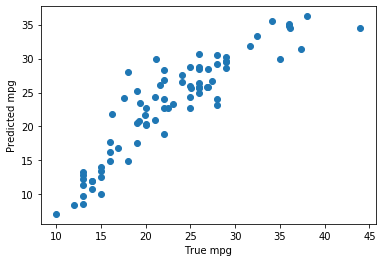

In [304]:
plt.scatter(y_test, y_predict)
plt.xlabel('True mpg')
plt.ylabel('Predicted mpg')

Refer to [this](http://scikit-learn.org/stable/modules/model_evaluation.html) to learn more about the other metrics and scoring methods offered by Sklearn.